In [5]:
pip install pandas scikit-learn joblib matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "/Users/lakshan/Documents/Projects/ai_anomaly/refined_thermostat_dataset.csv"

# Load Dataset
def load_data(file_path):
    print("📂 Attempting to load dataset...")

    try:
        data = pd.read_csv(file_path)
        print(f"✅ Dataset loaded successfully! Shape: {data.shape}")
        
        # Show the first few rows to verify content
        print("🔍 First 5 rows of the dataset:")
        print(data.head(), "\n")

        # Print column names to ensure they match expectations
        print("📋 Column Names in Dataset:", data.columns.tolist(), "\n")

        # Check for null values
        print("🟠 Null Values Summary:\n", data.isnull().sum(), "\n")

        # Check data types to ensure they are correct
        print("🧪 Data Types Summary:\n", data.dtypes, "\n")

        return data

    except FileNotFoundError:
        print(f"❌ Error: File not found at path: {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print("❌ Error: The file is empty.")
        return None
    except Exception as e:
        print(f"❌ Unexpected Error: {e}")
        return None

# Data Cleaning & Feature Engineering
def preprocess_data(data):
    print("🧹 Starting Data Preprocessing...")

    # Check for missing values before dropping
    missing_values = data.isnull().sum().sum()
    print(f"🔍 Missing Values Before Cleaning: {missing_values}")

    # Drop rows with missing values
    data.dropna(inplace=True)
    print(f"✅ Rows with missing values removed. New shape: {data.shape}\n")

    # Feature and Target Selection
    features = ['temperature', 'request_rate']  # Features for anomaly detection
    target = 'label'

    # Check if required columns are present
    if not all(col in data.columns for col in features + [target]):
        print(f"❌ Error: Required columns {features + [target]} are missing in the dataset.")
        return None, None, None, None, None

    X = data[features]
    y = (data[target] == 'ddos_attack').astype(int)  # Encode target as binary (1 = attack, 0 = normal)

    print("✅ Features and target selected successfully.\n")
    print(f"📊 Feature Sample:\n{X.head()}")
    print(f"🎯 Target Sample:\n{y.head()}\n")

    # Data Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("✅ Data scaling complete. Sample Scaled Data:\n", X_scaled[:5], "\n")

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )

    print(f"✅ Train-Test Split Complete: Train Size: {X_train.shape[0]} | Test Size: {X_test.shape[0]}\n")

    return X_train, X_test, y_train, y_test, scaler

# Execution Flow
data = load_data(file_path)
if data is not None:
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data)


📂 Attempting to load dataset...
✅ Dataset loaded successfully! Shape: (324, 6)
🔍 First 5 rows of the dataset:
   temperature  request_rate  temp_moving_avg  rate_change_temp  \
0     0.124731       -0.3125        -0.069725              0.01   
1    -1.526882       -0.2500        -0.069725             -1.19   
2    -0.288172       -0.3125        -0.069725              0.91   
3     0.744086       -0.1875        -0.069725              0.76   
4     0.055914       -0.1875        -0.069725             -0.49   

   rate_change_rate  label  
0              -0.5      0  
1               0.0      1  
2              -1.0      0  
3               0.5      0  
4              -0.5      0   

📋 Column Names in Dataset: ['temperature', 'request_rate', 'temp_moving_avg', 'rate_change_temp', 'rate_change_rate', 'label'] 

🟠 Null Values Summary:
 temperature         0
request_rate        0
temp_moving_avg     0
rate_change_temp    0
rate_change_rate    0
label               0
dtype: int64 

🧪 Data Type

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train the Model
def train_model(X_train, y_train):
    print("🤖 Training Random Forest model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("✅ Model training complete!\n")
    return model

# Evaluate Model
def evaluate_model(model, X_test, y_test):
    print("📊 Evaluating model...")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"✅ Model Accuracy: {acc * 100:.2f}%\n")
    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred))

# Save the Model and Scaler for Inference
def save_model(model, scaler, model_path='trained_model.joblib', scaler_path='scaler.joblib'):
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    print(f"✅ Model saved successfully at '{model_path}'")
    print(f"✅ Scaler saved successfully at '{scaler_path}'\n")

# Execution Flow
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)
save_model(model, scaler)


🤖 Training Random Forest model...
✅ Model training complete!

📊 Evaluating model...
✅ Model Accuracy: 100.00%

🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

✅ Model saved successfully at 'trained_model.joblib'
✅ Scaler saved successfully at 'scaler.joblib'



In [8]:
import joblib
import numpy as np

# Load Model and Scaler
def load_model(model_path='trained_model.joblib', scaler_path='scaler.joblib'):
    print("📥 Loading model and scaler...")
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        print("✅ Model and scaler loaded successfully!\n")
        return model, scaler
    except Exception as e:
        print(f"❌ Error loading model or scaler: {e}")
        return None, None

# Perform Inference
def predict_anomaly(model, scaler, temperature, request_rate):
    print(f"📡 New Data Received - Temp: {temperature}°C, Request Rate: {request_rate}")

    # Data Scaling
    scaled_data = scaler.transform([[temperature, request_rate]])

    # Prediction
    prediction = model.predict(scaled_data)[0]

    # Display Result
    if prediction == 1:
        print("🚨 DDoS ATTACK DETECTED!")
    else:
        print("✅ Data is NORMAL")

# Execution Flow
model, scaler = load_model()
if model and scaler:
    predict_anomaly(model, scaler, temperature=35.0, request_rate=1500)  # Sample data
    predict_anomaly(model, scaler, temperature=22.0, request_rate=2)   # Sample data


📥 Loading model and scaler...
✅ Model and scaler loaded successfully!

📡 New Data Received - Temp: 35.0°C, Request Rate: 1500
✅ Data is NORMAL
📡 New Data Received - Temp: 22.0°C, Request Rate: 2
✅ Data is NORMAL


/Users/lakshan/.pyenv/versions/miniconda3-latest/envs/iot_security/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/lakshan/.pyenv/versions/miniconda3-latest/envs/iot_security/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/Users/lakshan/.pyenv/versions/miniconda3-latest/envs/iot_security/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

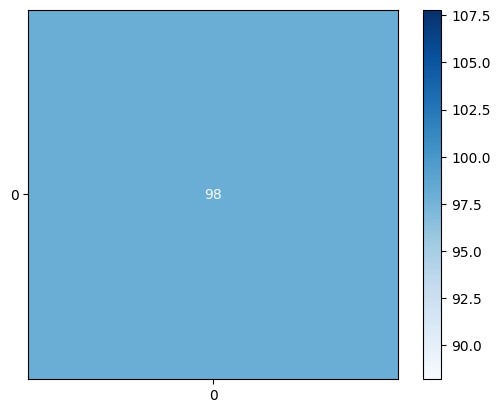

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualizing Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'DDoS Attack'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Visualizing Feature Importance
def plot_feature_importance(model, feature_names):
    feature_importances = model.feature_importances_
    sns.barplot(x=feature_importances, y=feature_names)
    plt.title("Feature Importance")
    plt.show()

# Execution Flow
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plot_feature_importance(model, ['temperature', 'request_rate'])


In [8]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


🧹 Cleaning Dataset...
✅ Outlier Removal Complete - New Shape: (288, 5)
🧪 Creating New Features...
⚖️ Balancing Dataset...
✅ Data Balancing Complete - New Class Distribution:
label
0    162
1    162
Name: count, dtype: int64
📏 Scaling Features...
📊 Visualizing Data...


/var/folders/bb/s4tr6hrx7fx_84jqcmhkvsjc0000gn/T/ipykernel_99798/480068308.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['temp_moving_avg'] = data['temperature'].rolling(window=5).mean().fillna(method='bfill')


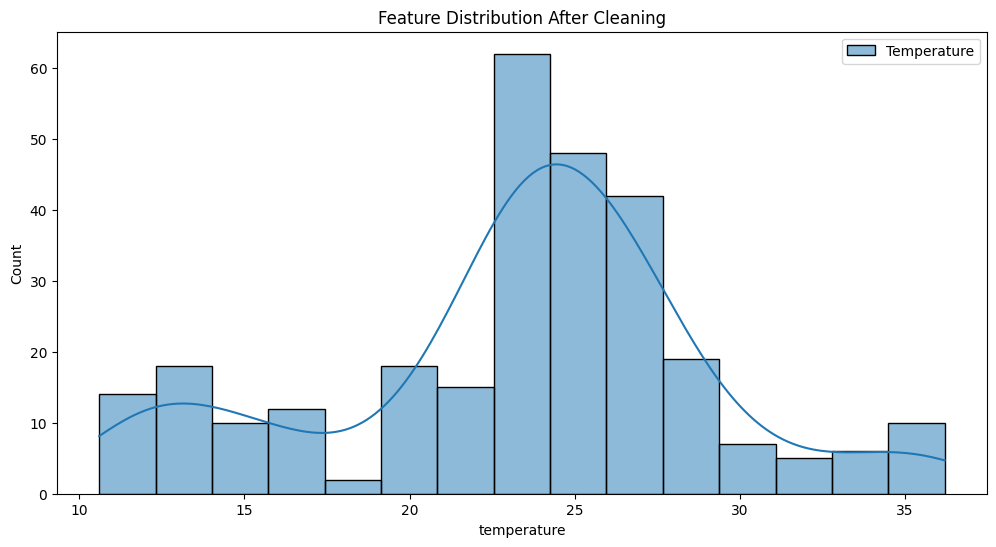

✅ Dataset Refinement Complete! Refined dataset saved as 'refined_thermostat_dataset.csv'


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
file_path = "/Users/lakshan/Documents/Projects/ai_anomaly/thermostat_dataset.csv"
data = pd.read_csv(file_path)

# ========================= Step 1: Data Cleaning =========================
print("🧹 Cleaning Dataset...")
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# ========================= Step 2: Outlier Removal =========================
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

data = remove_outliers(data, 'temperature')
data = remove_outliers(data, 'request_rate')
print(f"✅ Outlier Removal Complete - New Shape: {data.shape}")

# ========================= Step 3: Feature Engineering =========================
print("🧪 Creating New Features...")
data['temp_moving_avg'] = data['temperature'].rolling(window=5).mean().fillna(method='bfill')
data['rate_change_temp'] = data['temperature'].diff().fillna(0)
data['rate_change_rate'] = data['request_rate'].diff().fillna(0)

# ========================= Step 4: Data Balancing =========================
print("⚖️ Balancing Dataset...")
X = data[['temperature', 'request_rate', 'temp_moving_avg', 'rate_change_temp', 'rate_change_rate']]
y = (data['label'] == 'ddos_attack').astype(int)

# Apply SMOTE for oversampling minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"✅ Data Balancing Complete - New Class Distribution:\n{y_resampled.value_counts()}")

# ========================= Step 5: Scaling =========================
print("📏 Scaling Features...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_resampled)

# ========================= Step 6: Visual Analysis =========================
print("📊 Visualizing Data...")

plt.figure(figsize=(12, 6))
sns.histplot(data['temperature'], kde=True, label='Temperature')

plt.legend()
plt.title("Feature Distribution After Cleaning")
plt.show()

# ========================= Step 7: Save Refined Dataset =========================
refined_data = pd.DataFrame(X_scaled, columns=X.columns)
refined_data['label'] = y_resampled
refined_data.to_csv("refined_thermostat_dataset.csv", index=False)

print("✅ Dataset Refinement Complete! Refined dataset saved as 'refined_thermostat_dataset.csv'")


In [37]:
import pandas as pd

# Load Dataset
file_path = "augmented1_smart_plug_dataset.csv"
data = pd.read_csv(file_path)

# Display initial data distribution
print("🔍 Original Dataset Distribution:\n", data['label'].value_counts(), "\n")

# Calculate target distribution (70% normal, 30% DDoS)
total_ddos = data[data['label'] == 'ddos_attack'].shape[0]
target_normal = int((total_ddos / 0.3) * 0.7)  # Achieve 70:30 ratio

# Sample the required number of normal data points
normal_data = data[data['label'] == 'normal'].sample(n=target_normal, random_state=42)
ddos_data = data[data['label'] == 'ddos_attack']

# Combine both datasets
balanced_data = pd.concat([normal_data, ddos_data]).sample(frac=1, random_state=42)  # Shuffle data

# Display new data distribution
print("✅ Balanced Dataset Distribution:\n", balanced_data['label'].value_counts(), "\n")

# Save the balanced dataset
balanced_file_path = "smart_plug_dataset_balanced.csv"
balanced_data.to_csv(balanced_file_path, index=False)
print(f"📂 Balanced dataset saved as: {balanced_file_path}")


🔍 Original Dataset Distribution:
 label
normal         405
1              300
ddos_attack     95
Name: count, dtype: int64 

✅ Balanced Dataset Distribution:
 label
normal         221
ddos_attack     95
Name: count, dtype: int64 

📂 Balanced dataset saved as: smart_plug_dataset_balanced.csv


In [41]:
import pandas as pd

# Load dataset
file_path = "smart_plug_dataset_with_ddos.csv"
data = pd.read_csv(file_path)

# Display column names
print("📋 Column Names in Dataset:")
print(data.columns)


📋 Column Names in Dataset:
Index(['timestamp', 'device_id', 'power_w', 'voltage_v', 'current_a', 'label'], dtype='object')


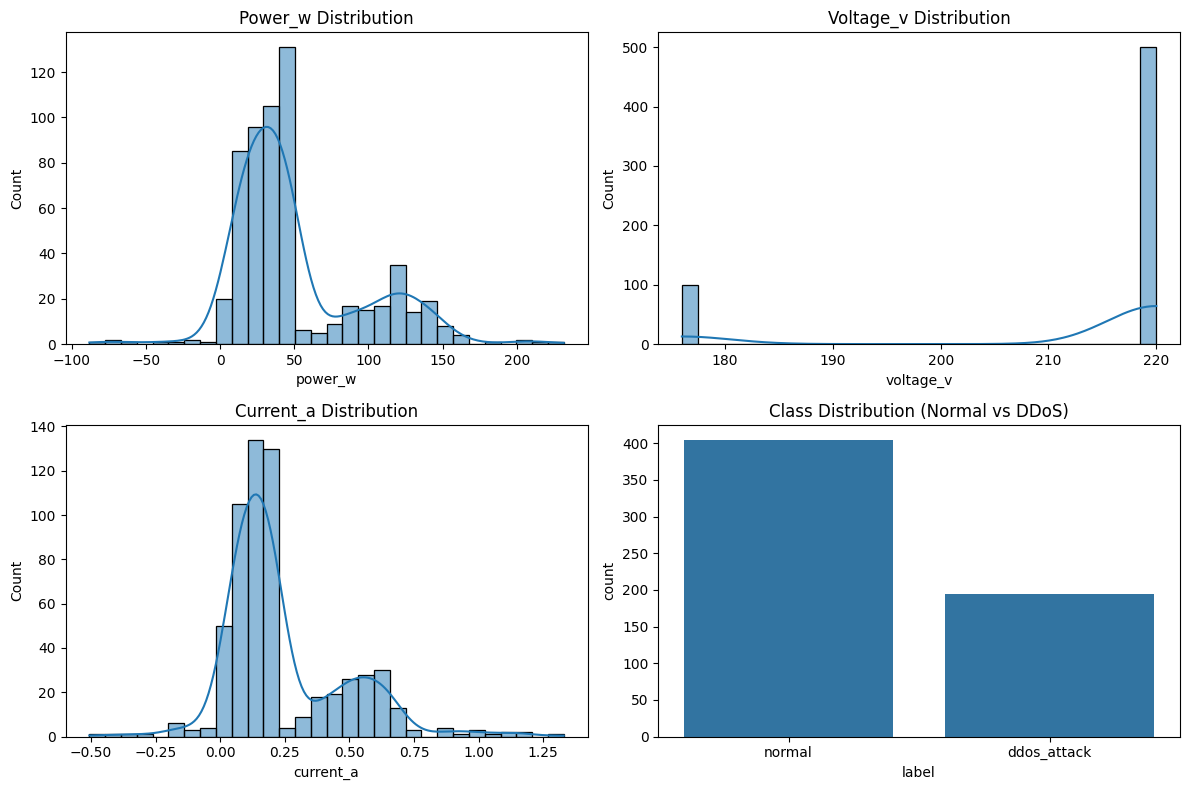

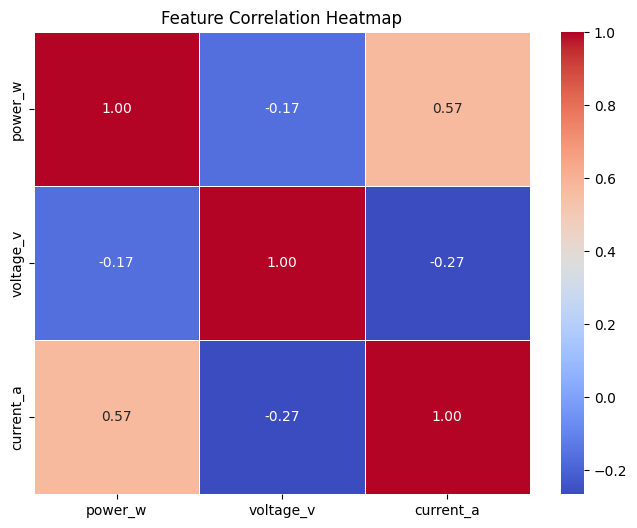

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "smart_plug_dataset_with_ddos.csv"
data = pd.read_csv(file_path)

# Visualization - Feature Distribution
plt.figure(figsize=(12, 8))
features = ['power_w', 'voltage_v', 'current_a']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f"{feature.capitalize()} Distribution")

# Class Distribution
plt.subplot(2, 2, 4)
sns.countplot(x='label', data=data)
plt.title('Class Distribution (Normal vs DDoS)')

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "smart_plug_dataset_with_ddos.csv"
data = pd.read_csv(file_path)

# Display column names for clarity
print("📋 Column Names in Dataset:", data.columns.tolist(), "\n")

# Feature Engineering
print("🛠️ Starting Feature Engineering...")

# Selecting Features and Target
features = ['power_w', 'voltage_v', 'current_a']
target = 'label'

# Encoding target (0 = Normal, 1 = DDoS Attack)
data[target] = (data[target] == 'ddos_attack').astype(int)

X = data[features]
y = data[target]

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"✅ Feature Engineering Complete: Train Size: {X_train.shape[0]} | Test Size: {X_test.shape[0]}\n")


📋 Column Names in Dataset: ['timestamp', 'device_id', 'power_w', 'voltage_v', 'current_a', 'label'] 

🛠️ Starting Feature Engineering...
✅ Feature Engineering Complete: Train Size: 420 | Test Size: 180



In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train the Random Forest model
def train_model(X_train, y_train):
    print("🤖 Training Random Forest model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("✅ Model training complete!\n")
    return model

# Evaluate Model
def evaluate_model(model, X_test, y_test):
    print("📊 Evaluating model...")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"✅ Model Accuracy: {acc * 100:.2f}%\n")
    print("🔍 Classification Report:\n", classification_report(y_test, y_pred))

# Save Model and Scaler
def save_model(model, scaler, model_path='trained_smartplug_model.joblib', scaler_path='smartplug_scaler.joblib'):
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    print(f"✅ Model saved successfully at '{model_path}'")
    print(f"✅ Scaler saved successfully at '{scaler_path}'\n")

# Execution Flow
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)
save_model(model, scaler)


🤖 Training Random Forest model...
✅ Model training complete!

📊 Evaluating model...
✅ Model Accuracy: 76.11%

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82       111
           1       0.77      0.54      0.63        69

    accuracy                           0.76       180
   macro avg       0.76      0.72      0.73       180
weighted avg       0.76      0.76      0.75       180

✅ Model saved successfully at 'trained_smartplug_model.joblib'
✅ Scaler saved successfully at 'smartplug_scaler.joblib'



In [40]:
import pandas as pd
import numpy as np

# Load Original Dataset
file_path = "smart_plug_dataset.csv"
data = pd.read_csv(file_path)

# Generate Synthetic DDoS Attack Data
def generate_ddos_data(original_data, num_samples=100):
    print(f"🚨 Generating {num_samples} synthetic DDoS attack entries...")

    # Extract realistic data ranges
    power_mean, power_std = original_data['power_w'].mean(), original_data['power_w'].std()
    voltage_mean, voltage_std = original_data['voltage_v'].mean(), original_data['voltage_v'].std()
    current_mean, current_std = original_data['current_a'].mean(), original_data['current_a'].std()

    # Create DDoS Attack Data (with exaggerated abnormal values)
    synthetic_ddos = pd.DataFrame({
        'timestamp': pd.date_range(start='2025-03-16 00:00:00', periods=num_samples, freq='10S'),
        'device_id': np.random.choice(original_data['device_id'].unique(), num_samples),
        'power_w': np.random.normal(power_mean * 1.5, power_std * 1.5, num_samples),  # Power spikes
        'voltage_v': np.random.normal(voltage_mean * 0.8, voltage_std * 1.8, num_samples),  # Voltage fluctuations
        'current_a': np.random.normal(current_mean * 2, current_std * 2, num_samples),  # Abnormal current
        'label': 'ddos_attack'
    })

    return synthetic_ddos

# Generate and Combine DDoS Data
synthetic_ddos = generate_ddos_data(data, num_samples=100)
enhanced_data = pd.concat([data, synthetic_ddos], ignore_index=True)

# Save the Enhanced Dataset
enhanced_file_path = "smart_plug_dataset_with_ddos.csv"
enhanced_data.to_csv(enhanced_file_path, index=False)

print(f"✅ Synthetic DDoS data added successfully! New Dataset Shape: {enhanced_data.shape}")
print(f"📂 Dataset saved at: {enhanced_file_path}")


🚨 Generating 100 synthetic DDoS attack entries...
✅ Synthetic DDoS data added successfully! New Dataset Shape: (600, 6)
📂 Dataset saved at: smart_plug_dataset_with_ddos.csv


/var/folders/bb/s4tr6hrx7fx_84jqcmhkvsjc0000gn/T/ipykernel_99798/1856157116.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'timestamp': pd.date_range(start='2025-03-16 00:00:00', periods=num_samples, freq='10S'),
